
# Simplicity of Naive Bayes Classifiers: Benefit and Bane


The goal of this notebook is to understand the **benefit and bane** of the Naive Bayes (NB) algorithm.

More specifically, we will **<font color=red> investigate the limitation</font>** of the NB classifier.

First, let's briefly discuss the benefit of the NB classifier.


## Benefit of "Simplicity"

The Naive Bayes algorithm is fueled by two "simplicity".
    - Simple inductive bias: conditional independence
    - Simple computation: statistical estimation of the prior and likelihood


In the NB classifier, we make a strong assumption: **given the class, the features are conditionaly independent**. The model is called "naive" because we do not expect the features to be independent, even conditional on the class label.

However, for solving text classification problems we have seen that although the naive Bayes assumption is an extremely strong assumption, the performance of the NB classifier was surprisingly good.

The reason NB classifier works well in text classification problems is that the conditional independence is a reasonalble assumption in the context of text classification. 

As an example, consider classifying emails into spam and ham. Words like "lottery", "prize" and "win" are all likely indicators that the email might be spam. On the other hand words like "Bayes", "Learning", "Classifier" are good indicators of a ham email. Thus, we could model the **probability of occurrence for each of these words independently, given the respective class** and then use it to score the likelihood of a text.



## Bane of "Simplicity"

However, the conditional independence assumption might not hold in some domains. For example, in image classification problems if we use pixel values to model the feature vectors, then the NB assumption fails. The reason is that the feature values (pixels) are not conditionally independent. The **pixels are not independently generated, depending only on the label**. If we look at a black pixel at one of the corners, the other pixels around is is likely to be black.

Thus, the NB assumption does not hold for the feature values (pixels) in an image classification problem.

Because of its simplicity, Naive Bayes was a very popular choice for building spam filters during 80s and 90s. However, for classifying images it is not as effective. The main reason, as we identified, is the inadequacy of its simplicity! The inductive bias (conditional independence assumption) simply doesn't hold in many domains (e.g., image classification).

It is due to this incorrect assumption about the "world", NB classifiers lost its popularity. Advanced models such as Artificial Neural Network was invented for image classification. 


In this notebook, we will use NB classifier to solve an image classification problem. We will compare the performance of the NB classifier with the K-Nearest Neighbor (KNN) memory-based model that we learned previously.


## Datset

We will use the MNIST dataset. It is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. 

Each image is labeled with the digit it represents. Each image is represented by 28 x 28 gray scale. There are 784 pixel values. Each value represents a pixel’s intensity, from 0 (white) to 255 (black). 


## NB Models for Investigation

We will model a feature vector (an image) as a 784 dimensional vector. Each dimension represents an individual pixel value. Since the pixels represent light intensity in the range of 0 ~ 255, we have two choices to model the feature values.

- Multi-valued categorical (value of a pixel can be 0 ~ 255)
- Real-valued


Thus, we will implement two NB classifiers:
- Gaussian NB model 
- Multinomial NB model

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

## Load Data

In [2]:
mnist = fetch_mldata('MNIST original')
#print(mnist)

X, y = mnist["data"], mnist["target"] 


print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)


/Users/hasan/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/hasan/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


## Display a Random Image

To display a digit, we need to reshape an instance’s feature vector to a 28 x 28 array. 

For displaying we use Matplotlib’s imshow() function:.

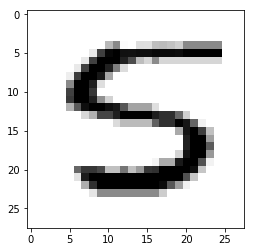

In [17]:
random_digit = X[34669]

random_digit_image = random_digit.reshape(28, 28)

plt.imshow(random_digit_image, cmap = plt.cm.binary, interpolation="nearest")
#plt.axis("off")
plt.show()

## Create Train-Test Set

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

However, we need to shuffle the training set. This will guarantee that all cross-validation folds will be similar because we don’t want one fold to be missing some digits. 

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Gaussian NB: Model Selection

We need to find the optimal value for the hyperparameter "var_smoothing".

It represents the portion of the largest variance of all features that is added to variances for calculation stability. Its default vale is 1e-9.

In [5]:
%%time
param_grid = {'var_smoothing': [0.001, 0.01, 0.1, 1.0]}

gnb = GaussianNB()

gnb = GridSearchCV(gnb, param_grid, scoring='accuracy', cv=5)
gnb.fit(X_train, y_train)

params_optimal = gnb.best_params_

print("Best Score (accuracy): %f" % gnb.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Best Score (accuracy): 0.800583
Optimal Hyperparameter Values:  {'var_smoothing': 0.1}
CPU times: user 1min 31s, sys: 56.6 s, total: 2min 27s
Wall time: 2min 27s


## Train The Optimal Gaussian NB Model

In [6]:
%%time
gaussianNB_clf = GaussianNB(**params_optimal)

gaussianNB_clf.fit(X_train, y_train) 

CPU times: user 533 ms, sys: 189 ms, total: 723 ms
Wall time: 722 ms


## Evaluate the Optimal Gaussian Model on Test Data

In [7]:
y_test_predicted = gaussianNB_clf.predict(X_test)


accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

precision_test = precision_score(y_test, y_test_predicted, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted, average='micro')
print("\nTest Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted, average='micro')
print("\nTest F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Accuracy:  0.814

Test Confusion Matrix:
[[ 901    0    0    4    1   14   21    1   34    4]
 [   0 1097    1    5    0    0    5    0   27    0]
 [  15   43  778   30    9    4   57   15   76    5]
 [   6   41   25  810    0   18   14   12   42   42]
 [   3    9    3    0  644    2   21    1   19  280]
 [  19   35    6   96   19  568   24   13   61   51]
 [  12   26   10    1    9   19  868    0   12    1]
 [   1   41    7    4   22    0    1  840   25   87]
 [   6   72    8   39   11   18   12    4  736   68]
 [   7   19    2    8   40    2    0   15   18  898]]

Test Precision = 0.814000

Test Recall = 0.814000

Test F1 Score = 0.814000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       980
         1.0       0.79      0.97      0.87      1135
         2.0       0.93      0.75      0.83      1032
         3.0       0.81      0.80      0.81      1010
         4.0       0.85      0.66      0.74       982
 

# Multinomial NB: Model Selection

We need to find the optimal value for the hyperparameter "alpha".

It is the additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing). Its default vale is 1.0

In [8]:
%%time
param_grid = {'alpha': [0.1, 1.0, 2.0]}

mnb = MultinomialNB()

mnb = GridSearchCV(mnb, param_grid, scoring='accuracy', cv=5)
mnb.fit(X_train, y_train)

params_optimal = mnb.best_params_

print("Best Score (accuracy): %f" % mnb.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Best Score (accuracy): 0.824283
Optimal Hyperparameter Values:  {'alpha': 0.1}
CPU times: user 21.1 s, sys: 7.36 s, total: 28.5 s
Wall time: 9.65 s


## Train The Optimal Multinomial NB Model

In [9]:
%%time

multinomialNB_clf = MultinomialNB(**params_optimal)

multinomialNB_clf.fit(X_train, y_train) 

CPU times: user 433 ms, sys: 200 ms, total: 633 ms
Wall time: 366 ms


## Evaluate the Optimal Multinomial Model on Test Data

In [10]:
y_test_predicted_mnb = multinomialNB_clf.predict(X_test)


accuracy_score_test = np.mean(y_test_predicted_mnb == y_test)
print("\nAccuracy: ", accuracy_score_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_mnb))

precision_test = precision_score(y_test, y_test_predicted_mnb, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted_mnb, average='micro')
print("\nTest Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted_mnb, average='micro')
print("\nTest F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted_mnb))


Accuracy:  0.8367

Test Confusion Matrix:
[[ 912    0    2    6    1    8   14    1   36    0]
 [   0 1061    5    9    0    2    6    0   51    1]
 [  15   11  859   23   10    3   33   11   66    1]
 [   4   11   34  851    1   21    7   14   40   27]
 [   2    2    6    0  732    0   25    1   38  176]
 [  23   11    6  107   18  590   17    6   78   36]
 [  16   13   17    1    7   25  861    0   18    0]
 [   1   21   11    5   18    0    1  861   40   70]
 [   6   26   13   54   14   27    8    9  777   40]
 [   6    7    3   10   66   10    0   17   27  863]]

Test Precision = 0.836700

Test Recall = 0.836700

Test F1 Score = 0.836700

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       980
         1.0       0.91      0.93      0.92      1135
         2.0       0.90      0.83      0.86      1032
         3.0       0.80      0.84      0.82      1010
         4.0       0.84      0.75      0.79       982


## Multinomial vs Gaussian Naive Bayes for Image Classification

The multinomial Naive Bayes classifier performs better than the Gaussian variant. 

In fact, each sample can be thought as a feature vector derived from a dictionary of 764 symbols. The value can be the count of each occurrence, so a multinomial distribution can better fit the data, while a Gaussian is slightly more limited by its mean and variance.


# KNN Classifier

The model selection for the KNN classifier on the MNIST dataset takes awefully long time. 

Below we provide the commented out code that we used to find the optimal KNN model.

In [ ]:
# %%time

# param_grid_knn = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

# knn = KNeighborsClassifier()

# knn_cv = GridSearchCV(knn, param_grid_knn, cv=5, verbose=3, n_jobs=-1)

# knn_cv.fit(X_train, y_train_5)

# params_optimal_knn = knn_cv.best_params_

# print("Best Score: %f" % knn_cv.best_score_)
# print("Optimal Hyperparameter Values: ", params_optimal_knn)

## Train The Optimal KNN Classifier

The optimal hyperparameters for the KNN model are:
- weights = "distance"
- n_neighbots = 4

In [12]:
%%time

knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')

knn_clf.fit(X_train, y_train)

y_test_predicted_knn = knn_clf.predict(X_test)

CPU times: user 10min 59s, sys: 1.07 s, total: 11min
Wall time: 11min


## Evaluate the Optimal KNN Model on Test Data

In [14]:

accuracy_score_test = np.mean(y_test_predicted_knn == y_test)
print("\nAccuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_knn))

precision_test = precision_score(y_test, y_test_predicted_knn, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted_knn, average='micro')
print("\nTest Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted_knn, average='micro')
print("\nTest F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted_knn))


Accuracy:  0.9714

Test Confusion Matrix:
[[ 973    1    1    0    0    1    3    1    0    0]
 [   0 1132    2    0    0    0    1    0    0    0]
 [  10    5  995    2    1    0    0   16    3    0]
 [   0    1    3  974    1   14    1    7    4    5]
 [   1    5    0    0  950    0    4    3    0   19]
 [   4    0    0    9    2  862    7    1    3    4]
 [   4    2    0    0    3    3  946    0    0    0]
 [   0   17    4    0    3    0    0  994    0   10]
 [   5    2    4   14    5   11    4    4  920    5]
 [   3    4    2    7    9    4    1   10    1  968]]

Test Precision = 0.971400

Test Recall = 0.971400

Test F1 Score = 0.971400

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       980
         1.0       0.97      1.00      0.98      1135
         2.0       0.98      0.96      0.97      1032
         3.0       0.97      0.96      0.97      1010
         4.0       0.98      0.97      0.97       982


## Observation:


While the KNN clssifier accuracy is 97%, the NB classifier (multinomial) accuracy is only about 83%. 

The poor perfomance of the NB classifier is due to the inadequacy of the naive Bayes assumption in the image classfication domain, especially when pixels represent the feature values. It is indeed incorrect to assume that each and every pixel are independently generated, depending only on the label. 

Thus, while we can independently compute the likelihood of the values of a feature vector in text classfication, and take the product of the individual likelihood values to estimate the feature vector likelihood, this is indeed not the case in image classification.

The words (mostly) in a document are representative micro-unit of the class of the document. Each word independetly bear the "smell" of the class.

However, in image classification, when we use pixel values as the values of a feature vector, they no more are representative of the class. The pixel micro-units don't have enough "information" to individually relate to the class of the feature.

However, we can use clusters of pixels (meaningful patches from an image) to define "visual words" and use them as components of the feature vector. By doing this we can extend the "bag of words" model to solve object classification in computer vision using NB algorithm.

More detail on object recognition using visual "bag of words" model:
http://vision.stanford.edu/teaching/cs231a_autumn1112/lecture/lecture15_bow_part-based_cs231a_marked.pdf


# <font color=red> Key Lesson:</font>

The success of the NB algorithm depends on the model the feature values. If the feature values (textual or visual words) independently relate to the class of the sample, then we can apply the NB assumption. And as long as we can apply the NB assumption meaningfully, the NB algorithm will perform well.